We are going to try to predict the likelihood that an HIV patient's infection will become less
severe, given a small dataset and limited clinical information.


This is a simple classification problem using csv data. Lets start by taking a look at the data
and preparing it if necessary.


In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Embedding, LSTM, concatenate
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras_tqdm import TQDMCallback


Using TensorFlow backend.


In [2]:
X = pd.read_csv('training_data.csv')
X.head()


,PatientID,Resp,PR Seq,RT Seq,VL-t0,CD4-t0
0,1,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCCCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAGCTAAAGCCAGGAA...,4.3,145
1,2,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.6,224
2,3,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAAGGTAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.2,1017
3,4,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAATAAGGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,5.7,206
4,5,0,CCTCAAATCACTCTTTGGCAACGACCCCTCGTCGCAGTAAAGATAG...,CCCATTAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,3.5,572


Col-1: patient ID  

Col-2: responder status ("1" for patients who improved and "0" otherwise)

Col-3: Protease nucleotide sequence (if available)

Col-4: Reverse Transciptase nucleotide sequence (if available)

Col-5: viral load at the beginning of therapy (log-10 units)

Col-6: CD4 count at the beginning of therapy

The Responder status indicates whether the patient improved after 16 weeks of therapy. 
Improvement is defined as a 100-fold decrease in the HIV-1 viral load.


We only have three numerical variables, but it still might be interesting to look at their correlations
  

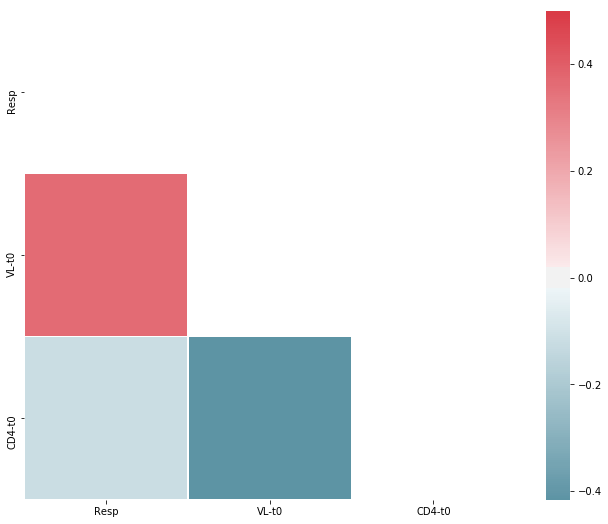

In [3]:
correlation_matrix = X.loc[:, X.columns != 'PatientID'].corr()
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=0.5, center=0, linewidth=.5, cbar={'shrink':.5})


In [4]:
print(f"Response correlation with CD4 = {X['Resp'].corr(X['CD4-t0'])}")
print(f"Response correlation with viral load at start = {X['Resp'].corr(X['VL-t0'])}")
print(f"Viral load correlation with CD4 = {X['VL-t0'].corr(X['CD4-t0'])}")


Response correlation with CD4 = -0.11862579883264826
Response correlation with viral load at start = 0.3623997929382554
Viral load correlation with CD4 = -0.4161793739610801


It seems the more of CD4 glycopretein is found at the start of the treatment the lesser the viral load is by a
factor of 0.42, which is pretty high.

And interestingly enough, the greater the viral load at the start, the greater the response to
treatment,  (which might imply that it is easier to drastically reduce viral load rather than
to completely remove it once it is already low).
 

We can now try to take a look at the variables containing the nucleotide sequences.
Since they are not numerical, and I cannot interpret them, I'll just take a look to see how unique they are.
(They should be unique, but lets just double check)


In [5]:
print(f"Total number of sequences = {len(X['PR Seq'])}")

print(f"Number of unique Protease sequences = {len(X['PR Seq'].unique())}")

print(f"Number of unique Reverse Transciptase sequences = {len(X['RT Seq'].unique())}")


Total number of sequences = 1000
Number of unique Protease sequences = 921
Number of unique Reverse Transciptase sequences = 1000


Since they are mostly unique we will have to try to find smaller patterns inside of them, otherwise the model will
basically ignore them, as comparing the full strings to each other will result in almost no correlation.

We can either try to divide them into codons (Three-letter 'words') formed from a sequence
of three nucleotides (e.g. 'ACT', 'CAG', 'TTT') or just feed the string as a sequence of
characters, leaving the data a little more unstructured, which might be even better, since the
less domain knowledge we pass to neural networks, the better they usually work,
as they are made to find patterns, and they are way better at it than we are.

Also since this type of data should be unique we are probably dealing with missing values.


In [6]:
duplicated_items = X[X['PR Seq'].duplicated(keep=False)]
duplicated_items.head()


,PatientID,Resp,PR Seq,RT Seq,VL-t0,CD4-t0
920,921,0,NaN,GAAATSTGTACAGAAATGSAAAAGGAAGGGAAAATTTCAAAAATTG...,4.1,227
921,922,0,NaN,AAATTAAAGCCAGGAATGGATGGCCCAAAGGTTAAACAATGGCCAT...,3.2,287
922,923,0,NaN,AGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAATGGATG...,3.0,638
923,924,1,NaN,CCCATAAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,4.5,699
924,925,0,NaN,CCCATAAGTCCTATTGAAACTGTACCAGTAAAATTAAAGCCAGGAA...,2.7,299


As expected, we have some missing values.
Lets see how many we have in order to decide what to do with them.


In [7]:
len(duplicated_items)


80

Since only 80 out of 1000 variables are missing we are just going to drop these rows, its not worth it trying to 
salvage the rest of the information on these patients as there are so few of them.


In [8]:
X = X.dropna()
len(X)


920

We should also check if the dataset is unbalanced (more instances of a class over another).
If so, the model will become stuck at a local optima predicting only the most prevalent class.


In [9]:
y = np.asarray(X[['Resp']])
percent_positives = np.count_nonzero(y) / len(y)
percent_positives



0.20326086956521738

Only around 20% of the dataset is positive, one of the simplest ways to solve this is to 
resample the dataset by creating 4 copies of each positive entry.


In [10]:
reps = [4 if val == 1 else 1 for val in X['Resp']]
X = X.loc[np.repeat(X.index.values, reps)]
len(X)



1481

Since this data is sequential we are going to need to keep the current structure of the data and pass it through 
a model that can interpret the nuances of the sequences in their order, such as a RNN (recurrent neural network).

In this case we will use a LSTM (long short term memory) network, which is a type of RNN.


Lets start by converting the characters into integers. Since we know there are only a few possible characters
we can create our own conversion algorithm rather than using their respective ASCII codes as it is usually done
or this type of problem, to save time and memory space.

While A, T, C, and G represent a particular nucleotide at a position, there are also letters that represent
ambiguity which are used when more than one kind of nucleotide could occur at that position.


In [11]:
def clean(x):
    x = x.replace("A", "1").replace("T", "2").replace("C", "3").replace("G", "4").replace("U", "5").replace("W", "6").replace("S", "7").replace("M", "8").replace("K", "9").replace("R", "10").replace("Y", "11").replace("B", "12").replace("D", "13").replace("H", "14").replace("V", "15").replace("N", "16").replace("Z", "17")
    return x
    
def transform_to_array(x):
    x = np.asarray(list(x), dtype=np.uint8)
    return x

X['PR Seq'] = X['PR Seq'].apply(clean)
X['PR Seq'] = X['PR Seq'].apply(transform_to_array)

X['RT Seq'] = X['RT Seq'].apply(clean)
X['RT Seq'] = X['RT Seq'].apply(transform_to_array)
    
X.head()


,PatientID,Resp,PR Seq,RT Seq,VL-t0,CD4-t0
0,1,0,"[3, 3, 2, 3, 1, 1, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",4.3,145
1,2,0,"[3, 3, 2, 3, 1, 1, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",3.6,224
2,3,0,"[3, 3, 2, 3, 1, 1, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",3.2,1017
3,4,0,"[3, 3, 2, 3, 1, 1, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",5.7,206
4,5,0,"[3, 3, 2, 3, 1, 1, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",3.5,572


Lets also check if the length of the sequences is variable in order to pass them properly to the model later.


In [12]:
print('PR: \n')
print(X['PR Seq'][:10].apply(len))
print("\nRT: \n")
print(X['RT Seq'][:10].apply(len))


PR: 

0    301
1    297
2    301
3    298
4    297
5    297
6    299
7    297
8    297
9    298
Name: PR Seq, dtype: int64

RT: 

0    1010
1     913
2     917
3    1457
4     910
5     902
6     915
7     914
8     909
9     901
Name: RT Seq, dtype: int64


The lengths are variable. We need to pad them with zeroes to create sequences of invariable length in order to
feed them as inputs to our network. Luckily Keras has a function just for that.

lets check their max lengths in order to define the size of the padded sequences.

In [13]:
max_PR = np.amax(X['PR Seq'].apply(len))
print(f'PR max = {max_PR}')

max_RT = np.amax(X['RT Seq'].apply(len))
print(f'RT max = {max_RT}')


PR max = 312
RT max = 1575


Lets split the dataset into train and test partitions.


In [14]:
train, test = train_test_split(X, test_size=0.25)

y_train = train[['Resp']]
X_train = train.drop('Resp', axis=1)

y_test = test[['Resp']]
X_test = test.drop('Resp', axis=1)


In [15]:
X_train.head()

,PatientID,PR Seq,RT Seq,VL-t0,CD4-t0
280,281,"[3, 3, 2, 3, 1, 4, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",3.7,77
591,592,"[3, 3, 2, 3, 1, 4, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",5.2,170
585,586,"[3, 3, 2, 3, 1, 4, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",5.0,75
416,417,"[3, 3, 2, 3, 1, 4, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",4.8,62
841,842,"[3, 3, 2, 3, 1, 1, 0, 1, 2, 3, 1, 3, 2, 3, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",3.6,533


In [16]:
y_train.head()

,Resp
280,0
591,1
585,1
416,0
841,0


In [17]:
X_test.head()

,PatientID,PR Seq,RT Seq,VL-t0,CD4-t0
642,643,"[3, 3, 2, 3, 1, 4, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",4.55,104
735,736,"[3, 3, 2, 3, 1, 4, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 3, 3, 3, 2, 1, 2, 2, ...",4.90,13
389,390,"[3, 3, 2, 3, 1, 4, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",3.55,238
125,126,"[3, 3, 2, 3, 1, 1, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 1, 1, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, ...",4.15,306
642,643,"[3, 3, 2, 3, 1, 4, 1, 2, 3, 1, 3, 2, 3, 2, 2, ...","[3, 3, 3, 1, 2, 2, 1, 4, 2, 3, 3, 2, 1, 2, 2, ...",4.55,104


In [18]:
y_test.head()


,Resp
642,1
735,1
389,0
125,0
642,1


And now to pad them with zeroes to get constant lengths for the model


In [19]:
padded_PR_train = sequence.pad_sequences(X_train['PR Seq'], maxlen=max_PR, dtype=np.uint8)

padded_RT_train = sequence.pad_sequences(X_train['RT Seq'], maxlen=max_RT, dtype=np.uint8)

padded_PR_test = sequence.pad_sequences(X_test['PR Seq'], maxlen=max_PR, dtype=np.uint8)

padded_RT_test = sequence.pad_sequences(X_test['RT Seq'], maxlen=max_RT, dtype=np.uint8)


In [20]:
print(f'pr_train =\n{padded_PR_train[0:5]},\nrt_train =\n{padded_RT_train[0:5]},\n'
      f'pr_test =\n{padded_PR_test[0:5]},\n rt_test =\n{padded_RT_test[0:5]}')


pr_train =
[[0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]],
rt_train =
[[0 0 0 ... 4 4 4]
 [0 0 0 ... 4 1 2]
 [0 0 0 ... 4 1 1]
 [0 0 0 ... 4 1 2]
 [0 0 0 ... 4 4 3]],
pr_test =
[[0 0 0 ... 2 2 3]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 2 2]
 [0 0 0 ... 2 1 1]
 [0 0 0 ... 2 2 3]],
 rt_test =
[[0 0 0 ... 3 1 4]
 [0 0 0 ... 4 4 3]
 [0 0 0 ... 3 1 4]
 [0 0 0 ... 3 2 4]
 [0 0 0 ... 3 1 4]]


Everything looks good so far, now we only need to build our binary classifier model.


We are going to build a wide model with two separate LSTM nodes and a simple fully connected node that merge at
end before passing a final fully connected layer and the actual prediction layer.

        

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)

epochs = 1000
batch_size = 16

vocab_size = 18 # There are 17 possible letters used on the sequences
embedding_vector_length = 128 # One of the hyperparameters to possibly be tuned, I chose this one almost arbitrarily,
# Just picking a small multiple of two for performance 

input_a = Input(shape=(max_PR, ))
input_b = Input(shape=(max_RT, ))
input_c = Input(shape=(2, ))

x1 = Embedding(vocab_size, embedding_vector_length)(input_a)
x1 = LSTM(100)(x1)
x1 = Model(inputs=input_a, outputs=x1)

x2 = Embedding(vocab_size, embedding_vector_length)(input_b)
x2 = LSTM(100)(x2)
x2 = Model(inputs=input_b, outputs=x2)

x3 = Dense(100, activation='relu')(input_c)
x3 = Model(inputs=input_c, outputs=x3)

combined = concatenate([x1.output, x2.output, x3.output])

fully_connected  = Dense(128, activation='relu')(combined)
prediction = Dense(1, activation='sigmoid')(fully_connected)

model = Model(inputs=[x1.input, x2.input, x3.input], outputs=prediction)

with open('model2_architecture.json', 'w') as f:
    f.write(model.to_json())


Instructions for updating:
Colocations handled automatically by placer.


In [22]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0003), metrics=['accuracy'])
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 312)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1575)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 312, 128)     2304        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1575, 128)    2304        input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (I

In [23]:
model.fit([
    padded_PR_train,
    padded_RT_train,
    X_train[['VL-t0', 'CD4-t0']]
    ],
    y_train,
    validation_data=([
                        padded_PR_test,
                        padded_RT_test,
                        X_test[['VL-t0', 'CD4-t0']]
                        ],
                        y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=[early_stopping, checkpoint, TQDMCallback()]
)



Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.73739, saving model to weights.hdf5

Epoch 00002: val_loss improved from 0.73739 to 0.65623, saving model to weights.hdf5

Epoch 00003: val_loss improved from 0.65623 to 0.64252, saving model to weights.hdf5

Epoch 00004: val_loss did not improve from 0.64252

Epoch 00005: val_loss improved from 0.64252 to 0.61527, saving model to weights.hdf5

Epoch 00006: val_loss did not improve from 0.61527

Epoch 00007: val_loss did not improve from 0.61527

Epoch 00008: val_loss did not improve from 0.61527

Epoch 00009: val_loss did not improve from 0.61527

Epoch 00010: val_loss did not improve from 0.61527


Training:   1%|          | 10/1000 [1:15:42<111:04:00, 403.88s/it]
